## Prometne nesreče v Sloveniji
Projektna naloga pri predmetu Podatkovno rudarjenje


Import podatkov za nesreče

In [1]:
import pandas as pd
file_path = 'podatki/pn2009_2023.csv' 

def load_accident_data(file_path):

    try:
       
        df = pd.read_csv(file_path, sep=',')  
        return df
    except FileNotFoundError:
        print(f"Error: File not found at path: {file_path}")
        return None
    except Exception as e:
        print(f"An error occurred while loading the data: {e}")
        return None

accident_data = load_accident_data(file_path)

### 1. Kje se dogaja največ nesreč?

Upravne enote kjer se je med leti 2009 in 2023 zgodilo največ nesreč

In [28]:
import geopandas as gpd
from shapely.geometry import Point
import folium
from folium.plugins import HeatMap
from IPython.display import display

if accident_data is not None:
    sample = accident_data.dropna(subset=["GeoKoordinataX", "GeoKoordinataY"]).sample(n=3000, random_state=42)
    sample["GeoKoordinataX"] = sample["GeoKoordinataX"].astype(str).str.replace(',', '.').astype(float)
    sample["GeoKoordinataY"] = sample["GeoKoordinataY"].astype(str).str.replace(',', '.').astype(float)

    geometry = [Point(xy) for xy in zip(sample["GeoKoordinataY"], sample["GeoKoordinataX"])]
    gdf = gpd.GeoDataFrame(sample, geometry=geometry, crs="EPSG:3794")
    gdf = gdf.to_crs(epsg=4326)

    heat_data = [[point.y, point.x] for point in gdf.geometry]

    m = folium.Map(location=[46.1512, 14.9955], zoom_start=8, tiles="CartoDB positron")

    HeatMap(heat_data, radius=10, blur=15, min_opacity=0.3).add_to(m)

    display(m)
else:
    print("Podatkovna datoteka ni bila uspešno naložena.")

Top 10 najbolj nevarnih odsekov (torej, na katerih odsekih se zgodi največ nesreč)

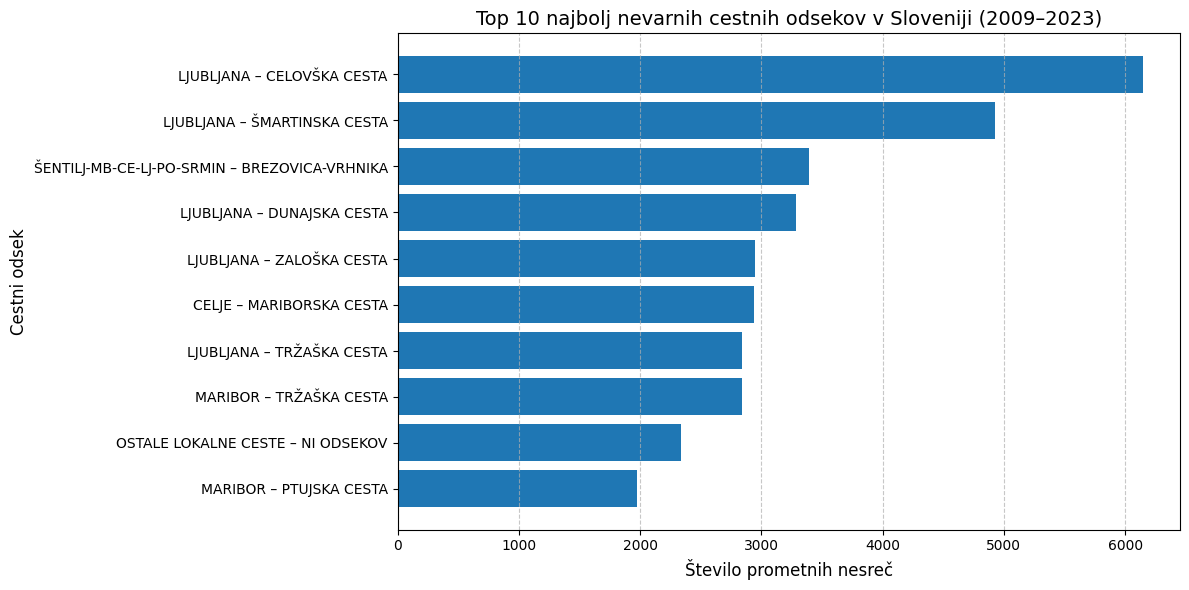

In [29]:
import matplotlib.pyplot as plt

top_odseki = (
    accident_data.groupby(["TekstCesteNaselja", "TekstOdsekaUlice"])
    .size()
    .sort_values(ascending=False)
    .reset_index(name="SteviloNesrec")
    .head(10)
)
top_odseki["OpisOdseka"] = top_odseki["TekstCesteNaselja"] + " – " + top_odseki["TekstOdsekaUlice"]

plt.figure(figsize=(12, 6))
plt.barh(top_odseki["OpisOdseka"], top_odseki["SteviloNesrec"])
plt.title("Top 10 najbolj nevarnih cestnih odsekov v Sloveniji (2009–2023)", fontsize=14)
plt.xlabel("Število prometnih nesreč", fontsize=12)
plt.ylabel("Cestni odsek", fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### 2. Najpogostejši vzroki za prometne nesreče


Osnovna statistika vzrokov nesreč:
Skupno število različnih vzrokov: 11
Top 5 vzrokov predstavlja 85.0% vseh nesreč

Najpogostejši vzroki za nesreče z deležem:
                                   count  Delež (%)  Kumulativni delež (%)
VzrokNesrece                                                              
PREMIKI Z VOZILOM                 123644  23.669133              23.669133
NEUPOŠTEVANJE PRAVIL O PREDNOSTI   88277  16.898839              40.567972
NEPRILAGOJENA HITROST              83660  16.015008              56.582980
NEUSTREZNA VARNOSTNA RAZDALJA      75122  14.380581              70.963561
NEPRAVILNA STRAN / SMER VOŽNJE     73313  14.034285              84.997846
OSTALO                             55869  10.694985              95.692832
NEPRAVILNO PREHITEVANJE            14229   2.723853              98.416685
NEPRAVILNOSTI PEŠCA                 3310   0.633632              99.050317
NEPRAVILNOSTI NA TOVORU             2613   0.500206              99.550523
NEPRAVILNOSTI 

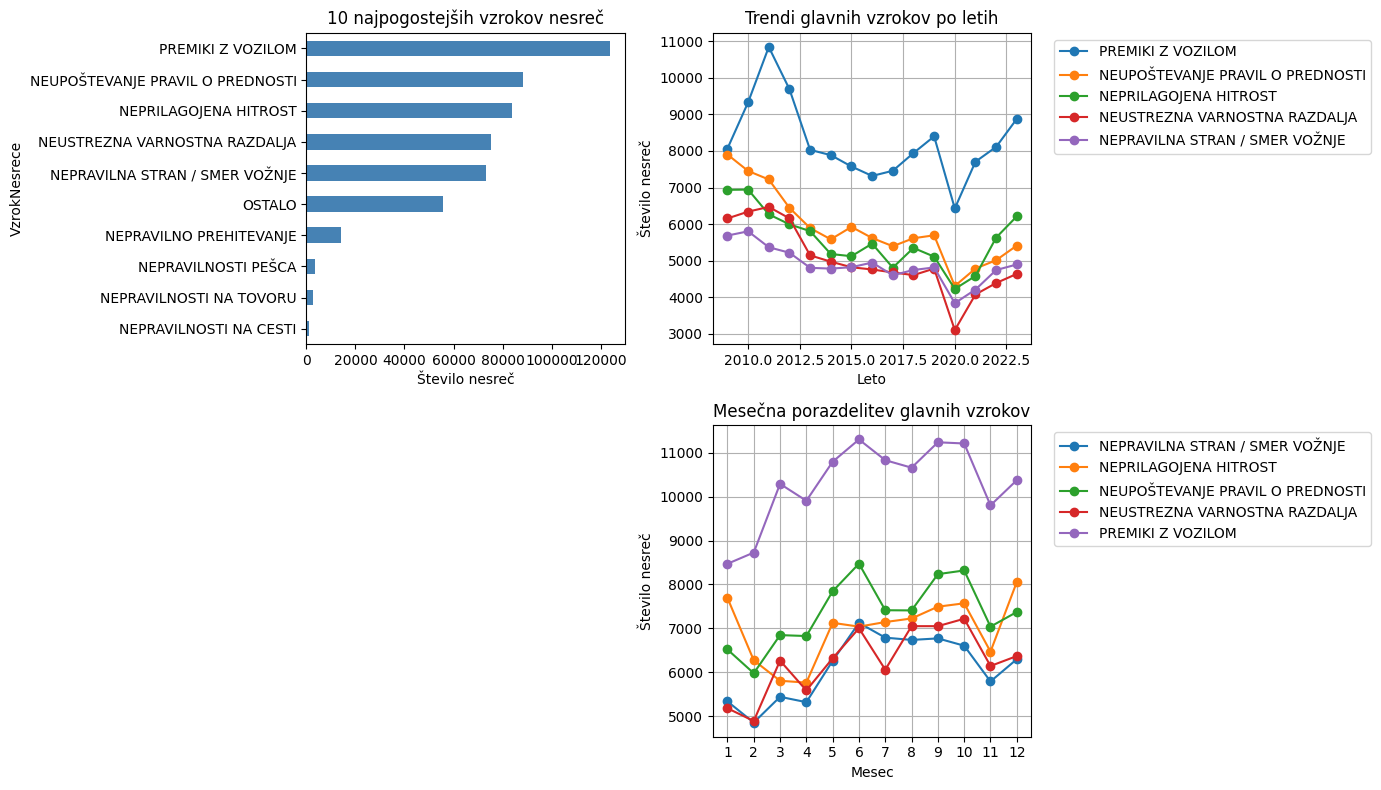


Vzroki z najvišjim deležem smrtnih žrtev:
PoskodbaUdelezenca                SMRT  Delež smrti (%)
VzrokNesrece                                           
NEPRAVILNOSTI PEŠCA                 65         1.971489
NEPRILAGOJENA HITROST              658         0.794868
NEPRAVILNA STRAN / SMER VOŽNJE     489         0.672766
NEPRAVILNO PREHITEVANJE             79         0.557910
NEUPOŠTEVANJE PRAVIL O PREDNOSTI   240         0.272854


In [18]:
import matplotlib.pyplot as plt

if accident_data is not None:
    vzroki_counts = accident_data['VzrokNesrece'].value_counts()
    
    print("\nOsnovna statistika vzrokov nesreč:")
    print(f"Skupno število različnih vzrokov: {len(vzroki_counts)}")
    print(f"Top 5 vzrokov predstavlja {vzroki_counts.head(5).sum()/len(accident_data)*100:.1f}% vseh nesreč")
    
    vzroki_po_letih = accident_data.groupby(['Leto', 'VzrokNesrece']).size().unstack().fillna(0)
    
    print("\nNajpogostejši vzroki za nesreče z deležem:")
    top_vzroki = vzroki_counts.head(10).to_frame()
    top_vzroki['Delež (%)'] = (top_vzroki['count'] / len(accident_data)) * 100
    top_vzroki['Kumulativni delež (%)'] = top_vzroki['Delež (%)'].cumsum()
    print(top_vzroki)
    
    glavni_vzroki = vzroki_counts.head(5).index.tolist()
    trendi_vzrokov = vzroki_po_letih[glavni_vzroki]
    
    plt.figure(figsize=(14, 8))
    
    # Graf 1: Najpogostejši vzroki
    plt.subplot(2, 2, 1)
    vzroki_counts.head(10).plot(kind='barh', color='steelblue')
    plt.title('10 najpogostejših vzrokov nesreč')
    plt.xlabel('Število nesreč')
    plt.gca().invert_yaxis()
    
    # Graf 2: Trendi glavnih vzrokov
    plt.subplot(2, 2, 2)
    for vzrok in glavni_vzroki:
        plt.plot(trendi_vzrokov.index, trendi_vzrokov[vzrok], label=vzrok, marker='o')
    plt.title('Trendi glavnih vzrokov po letih')
    plt.xlabel('Leto')
    plt.ylabel('Število nesreč')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    
    # Graf 4: Porazdelitev po mesecih za glavne vzroke
    plt.subplot(2, 2, 4)
    accident_data['Mesec'] = pd.to_datetime(accident_data['DatumPN'], errors='coerce').dt.month
    mesecna_porazdelitev = accident_data[accident_data['VzrokNesrece'].isin(glavni_vzroki)]
    mesecna_porazdelitev = mesecna_porazdelitev.groupby(['Mesec', 'VzrokNesrece']).size().unstack()
    mesecna_porazdelitev.plot(kind='line', marker='o', ax=plt.gca())
    plt.title('Mesečna porazdelitev glavnih vzrokov')
    plt.xlabel('Mesec')
    plt.ylabel('Število nesreč')
    plt.xticks(range(1, 13))
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()
    
    # Povezava med vzrokom in resnostjo nesreče
    resnost_vzrok = pd.crosstab(accident_data['VzrokNesrece'], 
                               accident_data['PoskodbaUdelezenca'])
    resnost_vzrok['Delež smrti (%)'] = resnost_vzrok['SMRT'] / resnost_vzrok.sum(axis=1) * 100
    print("\nVzroki z najvišjim deležem smrtnih žrtev:")
    print(resnost_vzrok.sort_values('Delež smrti (%)', ascending=False).head(5)[['SMRT', 'Delež smrti (%)']])
    
else:
    print("Napaka pri nalaganju podatkov")

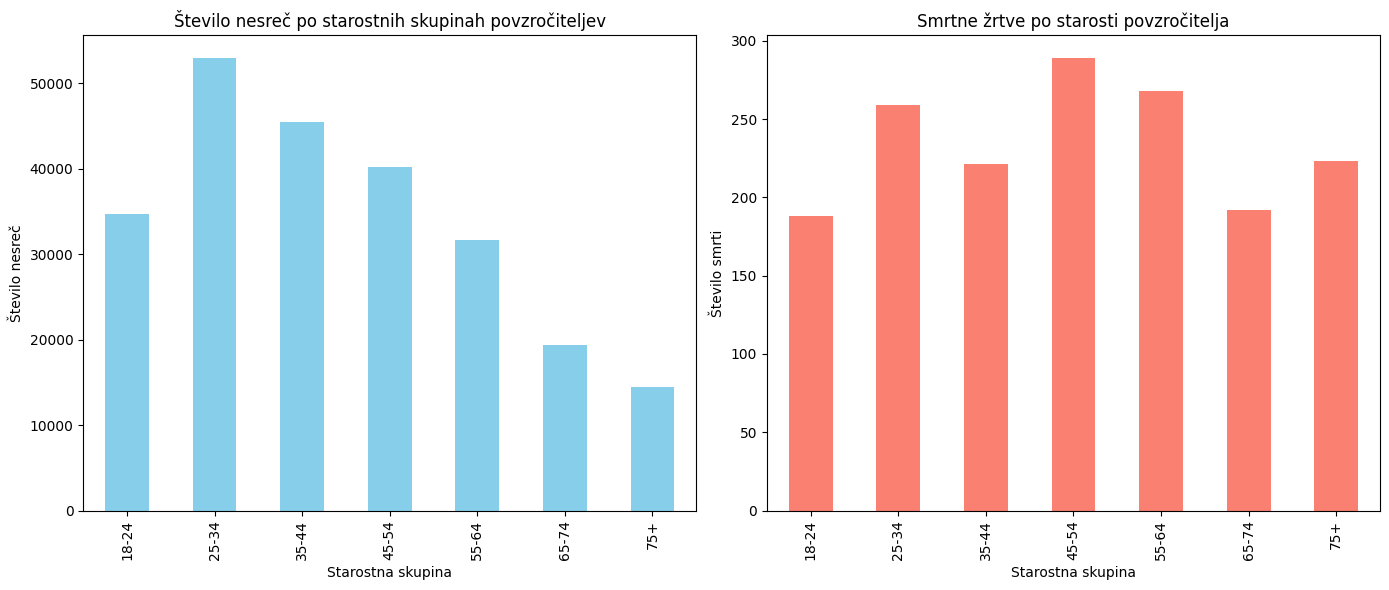

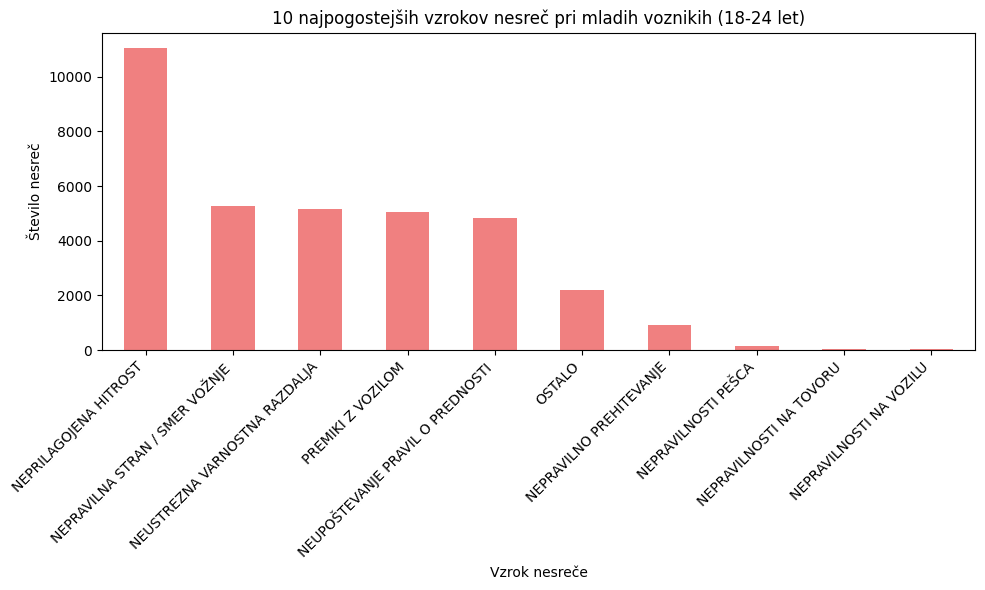


Statistika za mlade voznike (18-24 let):
Povprečna starost: 20.6 let
Delež med vsemi povzročitelji: 14.2%

5 najpogostejših vzrokov nesreč pri mladih voznikih:
VzrokNesrece
NEPRILAGOJENA HITROST               11048
NEPRAVILNA STRAN / SMER VOŽNJE       5275
NEUSTREZNA VARNOSTNA RAZDALJA        5159
PREMIKI Z VOZILOM                    5043
NEUPOŠTEVANJE PRAVIL O PREDNOSTI     4830
Name: count, dtype: int64


In [3]:
import matplotlib.pyplot as plt
import pandas as pd

def analyze_young_drivers(data, population_data=None):
    povzrocitelji = data[data['Povzrocitelj'] == 'POVZROČITELJ'].copy()

    bins = [18, 24, 34, 44, 54, 64, 74, 100]
    labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+']
    povzrocitelji.loc[:, 'StarostnaSkupina'] = pd.cut(povzrocitelji['Starost'], bins=bins, labels=labels, right=False)

    nesrece_po_starosti = povzrocitelji['StarostnaSkupina'].value_counts().sort_index()

    smrtni_nesrece = data[data['PoskodbaUdelezenca'] == 'SMRT']
    smrti_po_starosti = pd.cut(smrtni_nesrece['Starost'], bins=bins, labels=labels, right=False).value_counts().sort_index()

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    nesrece_po_starosti.plot(kind='bar', color='skyblue')
    plt.title('Število nesreč po starostnih skupinah povzročiteljev')
    plt.xlabel('Starostna skupina')
    plt.ylabel('Število nesreč')

    plt.subplot(1, 2, 2)
    smrti_po_starosti.plot(kind='bar', color='salmon')
    plt.title('Smrtne žrtve po starosti povzročitelja')
    plt.xlabel('Starostna skupina')
    plt.ylabel('Število smrti')

    plt.tight_layout()
    plt.show()

    mladi_povzrocitelji = povzrocitelji[povzrocitelji['StarostnaSkupina'] == '18-24']
    vzroki_mladi = mladi_povzrocitelji['VzrokNesrece'].value_counts().head(10) 
    plt.figure(figsize=(10, 6))
    vzroki_mladi.plot(kind='bar', color='lightcoral')
    plt.title('10 najpogostejših vzrokov nesreč pri mladih voznikih (18-24 let)')
    plt.xlabel('Vzrok nesreče')
    plt.ylabel('Število nesreč')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print("\nStatistika za mlade voznike (18-24 let):")
    mladi = povzrocitelji[povzrocitelji['StarostnaSkupina'] == '18-24']
    print(f"Povprečna starost: {mladi['Starost'].mean():.1f} let")
    print(f"Delež med vsemi povzročitelji: {len(mladi)/len(povzrocitelji)*100:.1f}%")
    print("\n5 najpogostejših vzrokov nesreč pri mladih voznikih:")
    print(mladi['VzrokNesrece'].value_counts().head(5))

analyze_young_drivers(accident_data)



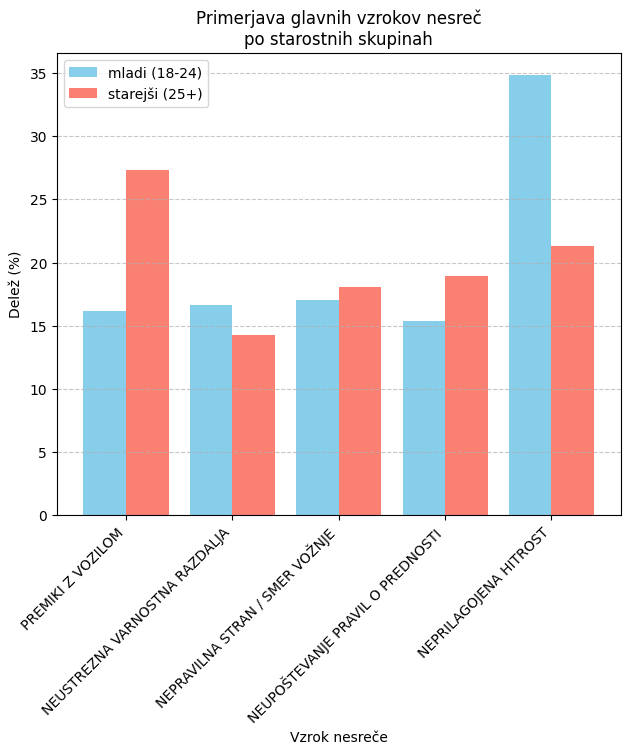

In [19]:
def compare_causes_and_alcohol(data):
    povzrocitelji = data[data['Povzrocitelj'] == 'POVZROČITELJ'].copy()
    povzrocitelji['StarostnaSkupina'] = ['mladi (18-24)' if 18 <= x <= 24 else 'starejši (25+)' for x in povzrocitelji['Starost']]
    
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 2, 1)
    
    top_vzroki_mladi = povzrocitelji[povzrocitelji['StarostnaSkupina'] == 'mladi (18-24)']['VzrokNesrece'].value_counts().head(5)
    top_vzroki_starejsi = povzrocitelji[povzrocitelji['StarostnaSkupina'] == 'starejši (25+)']['VzrokNesrece'].value_counts().head(5)
    
    vsi_vzroki = set(top_vzroki_mladi.index).union(set(top_vzroki_starejsi.index))
    
    vzroki_df = pd.DataFrame({
        'mladi (18-24)': povzrocitelji[povzrocitelji['StarostnaSkupina'] == 'mladi (18-24)']['VzrokNesrece'].value_counts(),
        'starejši (25+)': povzrocitelji[povzrocitelji['StarostnaSkupina'] == 'starejši (25+)']['VzrokNesrece'].value_counts()
    }).fillna(0)
    
    vzroki_df = vzroki_df.loc[list(vsi_vzroki)]
    
    vzroki_df = vzroki_df.div(vzroki_df.sum()) * 100
    
    vzroki_df.plot(kind='bar', ax=plt.gca(), width=0.8, color=['skyblue', 'salmon'])
    plt.title('Primerjava glavnih vzrokov nesreč\npo starostnih skupinah')
    plt.ylabel('Delež (%)')
    plt.xlabel('Vzrok nesreče')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
   

compare_causes_and_alcohol(accident_data)

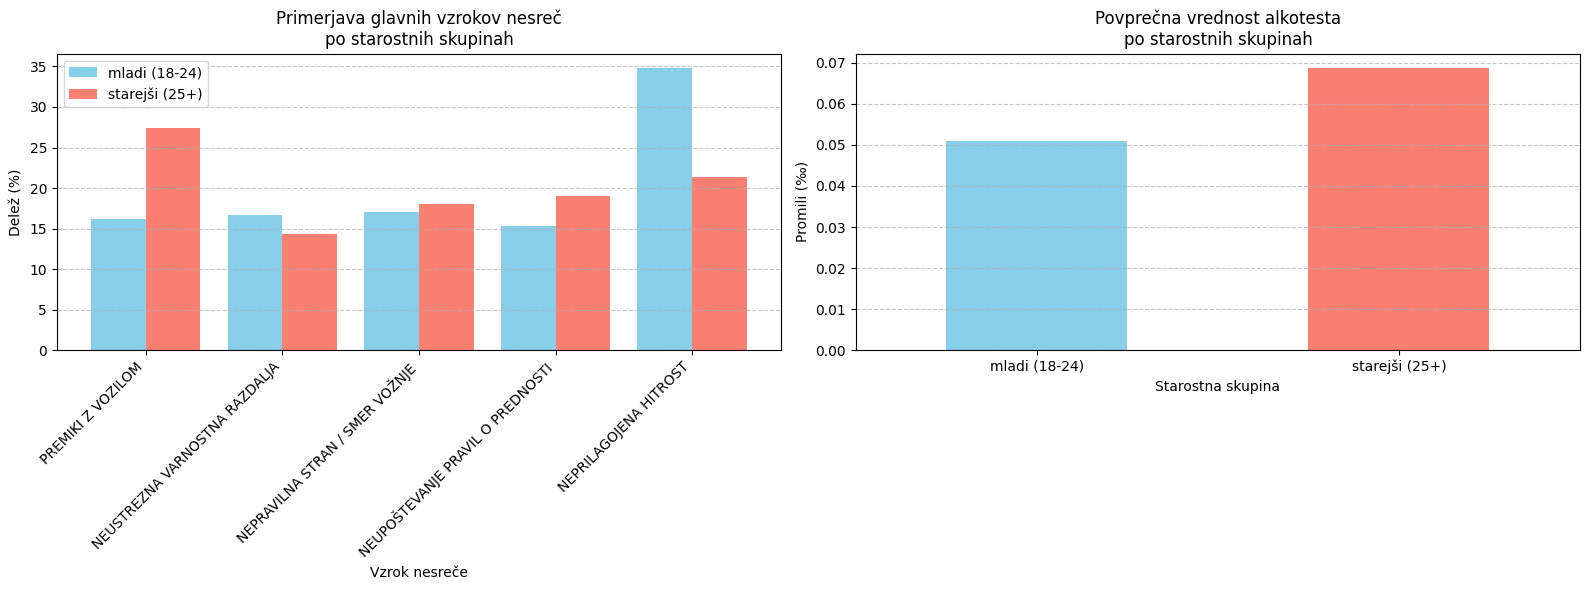

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

def compare_causes_and_alcohol(data):
    povzrocitelji = data[data['Povzrocitelj'] == 'POVZROČITELJ'].copy()
    
    povzrocitelji['VrednostAlkotesta'] = (
        povzrocitelji['VrednostAlkotesta']
        .astype(str)
        .str.replace(',', '.', regex=False)
        .str.replace('"', '', regex=False)
        .str.strip()
        .replace('', '0')
        .astype(float)
    )
    
    povzrocitelji['StarostnaSkupina'] = povzrocitelji['Starost'].apply(
        lambda x: 'mladi (18-24)' if 18 <= x <= 24 else 'starejši (25+)'
    )

    plt.figure(figsize=(16, 6))

    # Graf 1: Vzroki nesreč
    plt.subplot(1, 2, 1)
    top_vzroki_mladi = povzrocitelji[povzrocitelji['StarostnaSkupina'] == 'mladi (18-24)']['VzrokNesrece'].value_counts().head(5)
    top_vzroki_starejsi = povzrocitelji[povzrocitelji['StarostnaSkupina'] == 'starejši (25+)']['VzrokNesrece'].value_counts().head(5)
    vsi_vzroki = set(top_vzroki_mladi.index).union(set(top_vzroki_starejsi.index))

    vzroki_df = pd.DataFrame({
        'mladi (18-24)': povzrocitelji[povzrocitelji['StarostnaSkupina'] == 'mladi (18-24)']['VzrokNesrece'].value_counts(),
        'starejši (25+)': povzrocitelji[povzrocitelji['StarostnaSkupina'] == 'starejši (25+)']['VzrokNesrece'].value_counts()
    }).fillna(0)

    vzroki_df = vzroki_df.loc[list(vsi_vzroki)]
    vzroki_df = vzroki_df.div(vzroki_df.sum()) * 100

    vzroki_df.plot(kind='bar', ax=plt.gca(), width=0.8, color=['skyblue', 'salmon'])
    plt.title('Primerjava glavnih vzrokov nesreč\npo starostnih skupinah')
    plt.ylabel('Delež (%)')
    plt.xlabel('Vzrok nesreče')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Graf 2: Povprečna vrednost alkotesta
    plt.subplot(1, 2, 2)
    alkotest_po_skupinah = povzrocitelji.groupby('StarostnaSkupina')['VrednostAlkotesta'].mean()
    alkotest_po_skupinah.plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title('Povprečna vrednost alkotesta\npo starostnih skupinah')
    plt.ylabel('Promili (‰)')
    plt.xlabel('Starostna skupina')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

compare_causes_and_alcohol(accident_data)
